In [29]:
# Set the random seed so that you get the same numbers
import numpy as np
np.random.seed(42)


import xarray as xr
import arpes.xarray_extensions # so .G is in scope

test_data = xr.DataArray(
    np.random.random((3,3)),
    coords={"X": [0, 1, 2], "Y": [-5, -4, -3]},
    dims=["X", "Y"]
)
test_data.values

array([[0.37454012, 0.95071431, 0.73199394],
       [0.59865848, 0.15601864, 0.15599452],
       [0.05808361, 0.86617615, 0.60111501]])

In [2]:
print("Constant X")
for coordinate, constant_x_cut in test_data.G.iterate_axis("X"):
    print(coordinate, constant_x_cut.values)

print("\nConstant Y")
for coordinate, constant_y_cut in test_data.G.iterate_axis("Y"):
    print(coordinate, constant_y_cut.values)

Constant X
{'X': 0} [0.37454012 0.95071431 0.73199394]
{'X': 1} [0.59865848 0.15601864 0.15599452]
{'X': 2} [0.05808361 0.86617615 0.60111501]

Constant Y
{'Y': -5} [0.37454012 0.59865848 0.05808361]
{'Y': -4} [0.95071431 0.15601864 0.86617615]
{'Y': -3} [0.73199394 0.15599452 0.60111501]


In [3]:
for coordinate in test_data.G.iter_coords():
    print(coordinate)

{'X': 0, 'Y': -5}
{'X': 0, 'Y': -4}
{'X': 0, 'Y': -3}
{'X': 1, 'Y': -5}
{'X': 1, 'Y': -4}
{'X': 1, 'Y': -3}
{'X': 2, 'Y': -5}
{'X': 2, 'Y': -4}
{'X': 2, 'Y': -3}


In [4]:
for index, coordinate in test_data.G.enumerate_iter_coords():
    print(index, coordinate)

(0, 0) {'X': 0, 'Y': -5}
(0, 1) {'X': 0, 'Y': -4}
(0, 2) {'X': 0, 'Y': -3}
(1, 0) {'X': 1, 'Y': -5}
(1, 1) {'X': 1, 'Y': -4}
(1, 2) {'X': 1, 'Y': -3}
(2, 0) {'X': 2, 'Y': -5}
(2, 1) {'X': 2, 'Y': -4}
(2, 2) {'X': 2, 'Y': -3}


C:\Users\hellbrue\AppData\Local\Temp\ipykernel_22244\4165773806.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


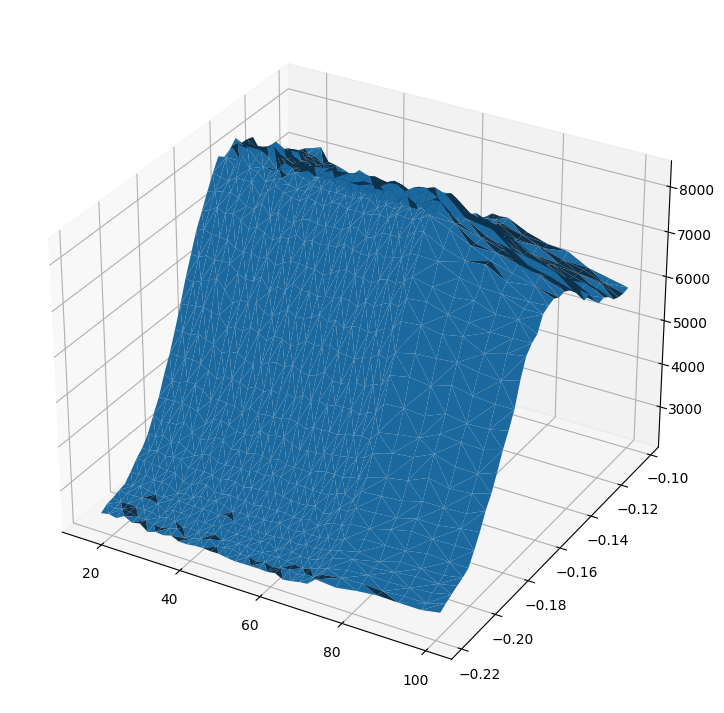

In [7]:
from arpes.io import example_data
import matplotlib.pyplot as plt

data = example_data.temperature_dependence.spectrum.sel(
    eV=slice(-0.08, 0.05), phi=slice(-0.22, None)).sum("eV")

raveled = data.G.ravel()
fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection="3d")

ax.plot_trisurf(
    raveled["temperature"], # use temperature as the X coordinates
    raveled["phi"],         # use phi as the Y coordinates
    data.values.T.ravel()   # use the intensity as the Z coordinate
)

In [13]:
raveled

{'temperature': array([16.  , 18.  , 20.  , ..., 90.06, 95.44, 99.98]),
 'phi': array([-0.21745469, -0.21745469, -0.21745469, ..., -0.10301067,
        -0.10301067, -0.10301067]),
 'data': array([2361.84375, 2457.4375 , 2484.53125, ..., 5859.28125, 5841.21875,
        5864.84375])}

In [16]:
one_dim = test_data.sum("X")
one_dim

<xarray.DataArray (Y: 3)>
array([1.03128222, 1.97290909, 1.48910347])
Coordinates:
  * Y        (Y) int32 -5 -4 -3

In [17]:
one_dim.G.to_arrays()

(array([-5, -4, -3]), array([1.03128222, 1.97290909, 1.48910347]))

In [23]:
test_data.G.filter_coord("Y", lambda y, _: y != -4)

<xarray.DataArray (X: 3, Y: 2)>
array([[0.37454012, 0.73199394],
       [0.59865848, 0.15599452],
       [0.05808361, 0.60111501]])
Coordinates:
  * X        (X) int32 0 1 2
  * Y        (Y) int32 -5 -3

In [24]:
test_data.G.map(lambda v: v + 1)

<xarray.DataArray (X: 3, Y: 3)>
array([[1.37454012, 1.95071431, 1.73199394],
       [1.59865848, 1.15601864, 1.15599452],
       [1.05808361, 1.86617615, 1.60111501]])
Coordinates:
  * X        (X) int32 0 1 2
  * Y        (Y) int32 -5 -4 -3

In [30]:
test_data.G.map_axes("Y", lambda v, c: v / np.linalg.norm(v))

<xarray.DataArray (X: 3, Y: 3)>
array([[0.52859931, 0.73382829, 0.76253974],
       [0.84490405, 0.12042618, 0.16250411],
       [0.08197508, 0.66857578, 0.62619929]])
Coordinates:
  * X        (X) int32 0 1 2
  * Y        (Y) int32 -5 -4 -3

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/34 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


Text(0.5, 1.0, 'Shifted to align Fermi angle')

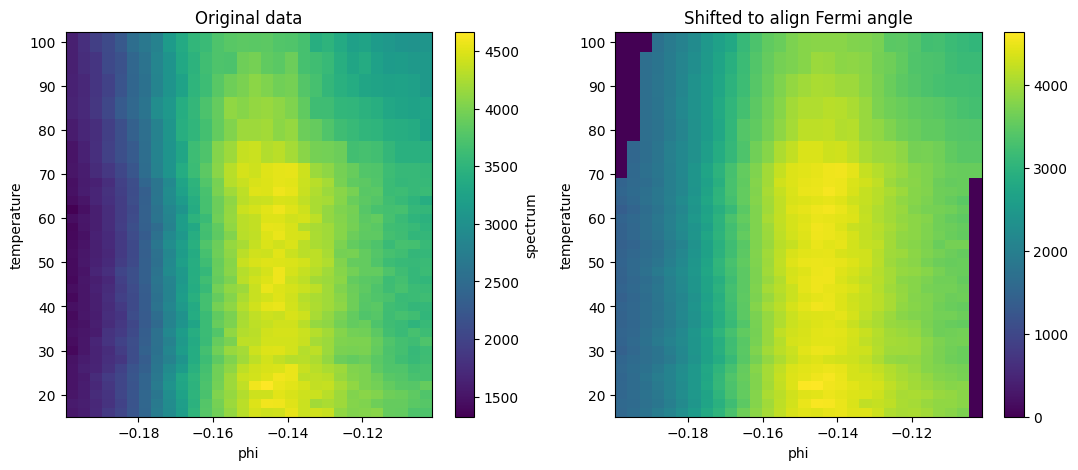

In [31]:
# first, get the same cut and fermi angles/momenta from the previous page
# this is reproduced for clarity and so you can run the whole notebook
# please feel free to skip...

from arpes.fits.utilities import broadcast_model
from arpes.fits.fit_models import LorentzianModel, AffineBackgroundModel

temp_dep = example_data.temperature_dependence
near_ef = temp_dep.sel(
    eV=slice(-0.05, 0.05),
    phi=slice(-0.2, None)
).sum("eV").spectrum

phis = broadcast_model(
    [AffineBackgroundModel, LorentzianModel], near_ef, "temperature",
).F.p("b_center")

# ...to here
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
near_ef.S.plot(ax=ax[0])
near_ef.G.shift_by(phis - phis.mean(), shift_axis="phi").S.plot(ax=ax[1])

ax[0].set_title("Original data")
ax[1].set_title("Shifted to align Fermi angle")

In [32]:
phis - phis.mean()

<xarray.DataArray (temperature: 34)>
array([ 0.00126065,  0.00018086,  0.00066414,  0.00073384,  0.00095287,
        0.00145268,  0.00083678,  0.00083174,  0.00118764,  0.00155194,
        0.00109393,  0.00131161,  0.00115931,  0.00081739,  0.00139065,
        0.00104621,  0.0015716 ,  0.00143711,  0.00104435,  0.00012413,
        0.00165145,  0.00135508,  0.00150913,  0.00083291,  0.00138959,
        0.00079786,  0.00026548, -0.00103171, -0.00261779, -0.00349027,
       -0.00481421, -0.00430856, -0.00520075, -0.00698767])
Coordinates:
  * temperature  (temperature) float64 16.0 18.0 20.0 22.0 ... 90.06 95.44 99.98
    x            float64 0.193
    y            float64 -1.298
    z            float64 -2.939
    theta        float64 0.2273
    beta         float64 0.0
    chi          float64 -0.2618
    hv           float64 55.4
    alpha        float64 1.571
    psi          int32 0